In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
df = pd.read_parquet('../data/processed/kimore_samples.parquet.gzip')
FEATURES = ['pos_x', 'pos_y', 'pos_z']

JOINTS_COUNT = len(df['joint'].unique())
print(f'joints_count={JOINTS_COUNT}')

df

joints_count=19


,type,subject,exercise,frame,joint,pos_x,pos_y,pos_z
0,CG/Expert,E_ID15,1,0,0,-0.075094,-0.448098,2.71395
1,CG/Expert,E_ID15,1,0,1,-0.094883,-0.131021,2.72260
2,CG/Expert,E_ID15,1,0,2,-0.113697,0.178819,2.71724
3,CG/Expert,E_ID15,1,0,3,-0.109840,0.312625,2.70704
4,CG/Expert,E_ID15,1,0,4,-0.272865,0.045073,2.70921
...,...,...,...,...,...,...,...,...
4449529,GPP/BackPain,B_ID7,4,571,14,-0.399774,-1.000100,2.76383
4449530,GPP/BackPain,B_ID7,4,571,16,-0.183834,-0.249004,2.58787
4449531,GPP/BackPain,B_ID7,4,571,17,-0.074817,-0.618989,2.69218
4449532,GPP/BackPain,B_ID7,4,571,18,0.019925,-0.990639,2.76021


                 type subject  exercise  frame  joint     pos_x     pos_y  \
0           CG/Expert  E_ID15         1      0      0 -0.075094 -0.448098   
1           CG/Expert  E_ID15         1      0      1 -0.094883 -0.131021   
2           CG/Expert  E_ID15         1      0      2 -0.113697  0.178819   
3           CG/Expert  E_ID15         1      0      3 -0.109840  0.312625   
4           CG/Expert  E_ID15         1      0      4 -0.272865  0.045073   
...               ...     ...       ...    ...    ...       ...       ...   
4402979  GPP/BackPain   B_ID7         1    560     14 -0.379784 -1.038570   
4402980  GPP/BackPain   B_ID7         1    560     16 -0.157534 -0.306542   
4402981  GPP/BackPain   B_ID7         1    560     17 -0.118957 -0.667594   
4402982  GPP/BackPain   B_ID7         1    560     18 -0.115158 -1.043430   
4402983  GPP/BackPain   B_ID7         1    560     20 -0.234861  0.234019   

           pos_z  
0        2.71395  
1        2.72260  
2        2.71724  

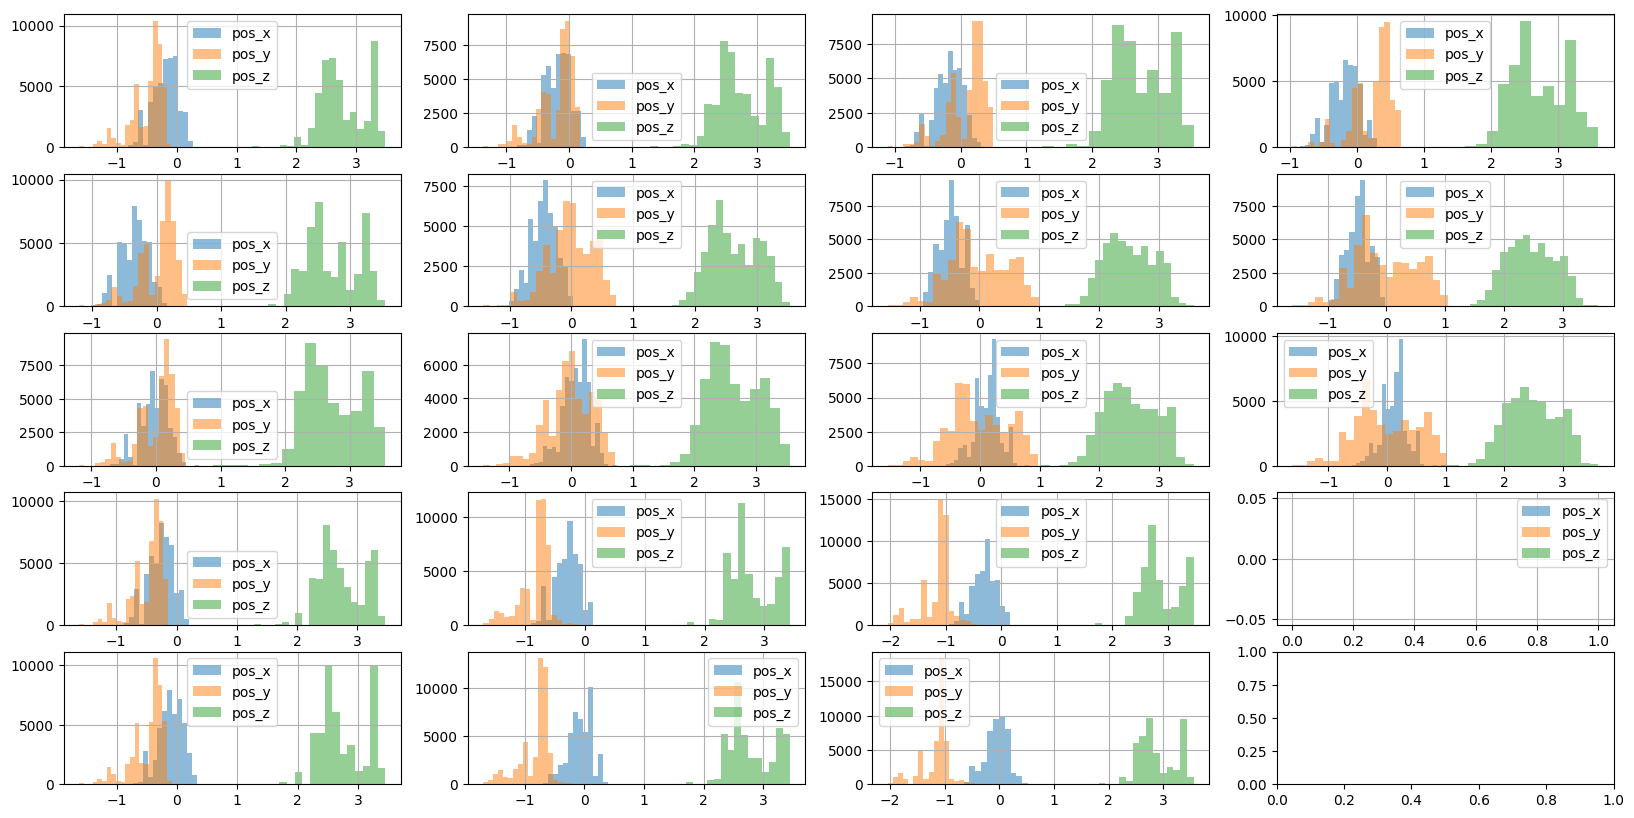

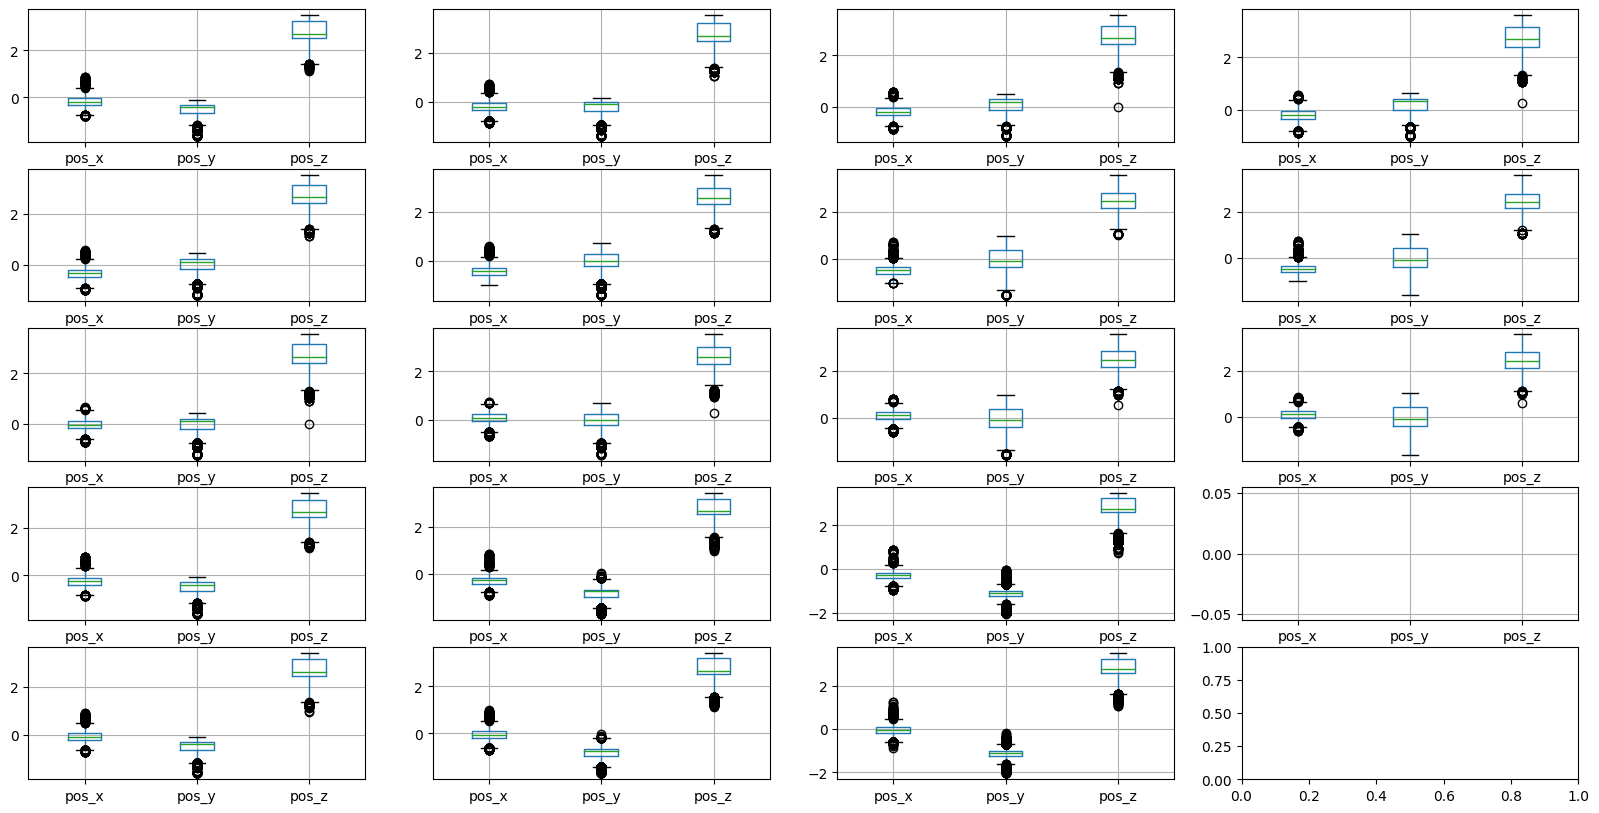

In [29]:
# Plot initial data distribution
exercise = df[df['exercise'] == 1]

def plot_hist(data, **kargs):
    for feature in FEATURES:
        data[feature].hist(legend=True, **kargs)

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20,10))
for joint, ax in zip(range(0, JOINTS_COUNT), axs.flat):
    plot_hist(exercise[exercise['joint'] == joint], ax=ax, alpha=0.5, bins=20)

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20,10))
for joint, ax in zip(range(0, JOINTS_COUNT), axs.flat):
    exercise[exercise['joint'] == joint][FEATURES].boxplot(ax=ax)

print(exercise)

In [28]:
print(exercise[(exercise['joint'] == 0)])

                 type subject  exercise  frame  joint     pos_x     pos_y  \
0           CG/Expert  E_ID15         1      0      0 -0.075094 -0.448098   
19          CG/Expert  E_ID15         1      1      0 -0.075091 -0.448099   
38          CG/Expert  E_ID15         1      2      0 -0.075385 -0.447611   
57          CG/Expert  E_ID15         1      3      0 -0.075529 -0.447579   
76          CG/Expert  E_ID15         1      4      0 -0.075513 -0.447599   
...               ...     ...       ...    ...    ...       ...       ...   
4402889  GPP/BackPain   B_ID7         1    556      0 -0.239538 -0.312336   
4402908  GPP/BackPain   B_ID7         1    557      0 -0.239384 -0.312444   
4402927  GPP/BackPain   B_ID7         1    558      0 -0.239389 -0.312491   
4402946  GPP/BackPain   B_ID7         1    559      0 -0.239444 -0.312552   
4402965  GPP/BackPain   B_ID7         1    560      0 -0.239449 -0.312584   

           pos_z  
0        2.71395  
19       2.71396  
38       2.71382  

pos_x   -0.179571
pos_y   -0.280138
pos_z    2.696997
dtype: float64 pos_x    0.274403
pos_y    0.544273
pos_z    0.410875
dtype: float64


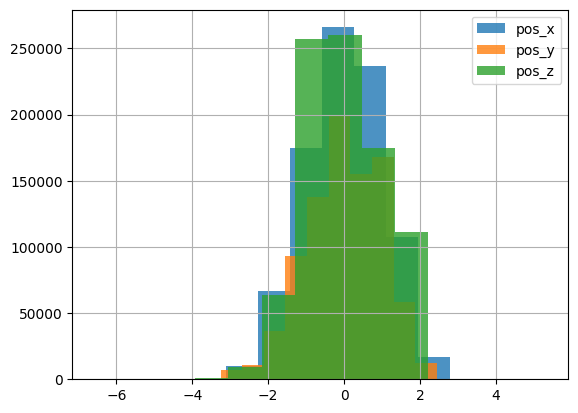

In [4]:
# Standardize globally

mean = exercise[FEATURES].mean()
std  = exercise[FEATURES].std()
print(mean, std)

z = (exercise - mean) / std
plot_hist(z, alpha=0.8)

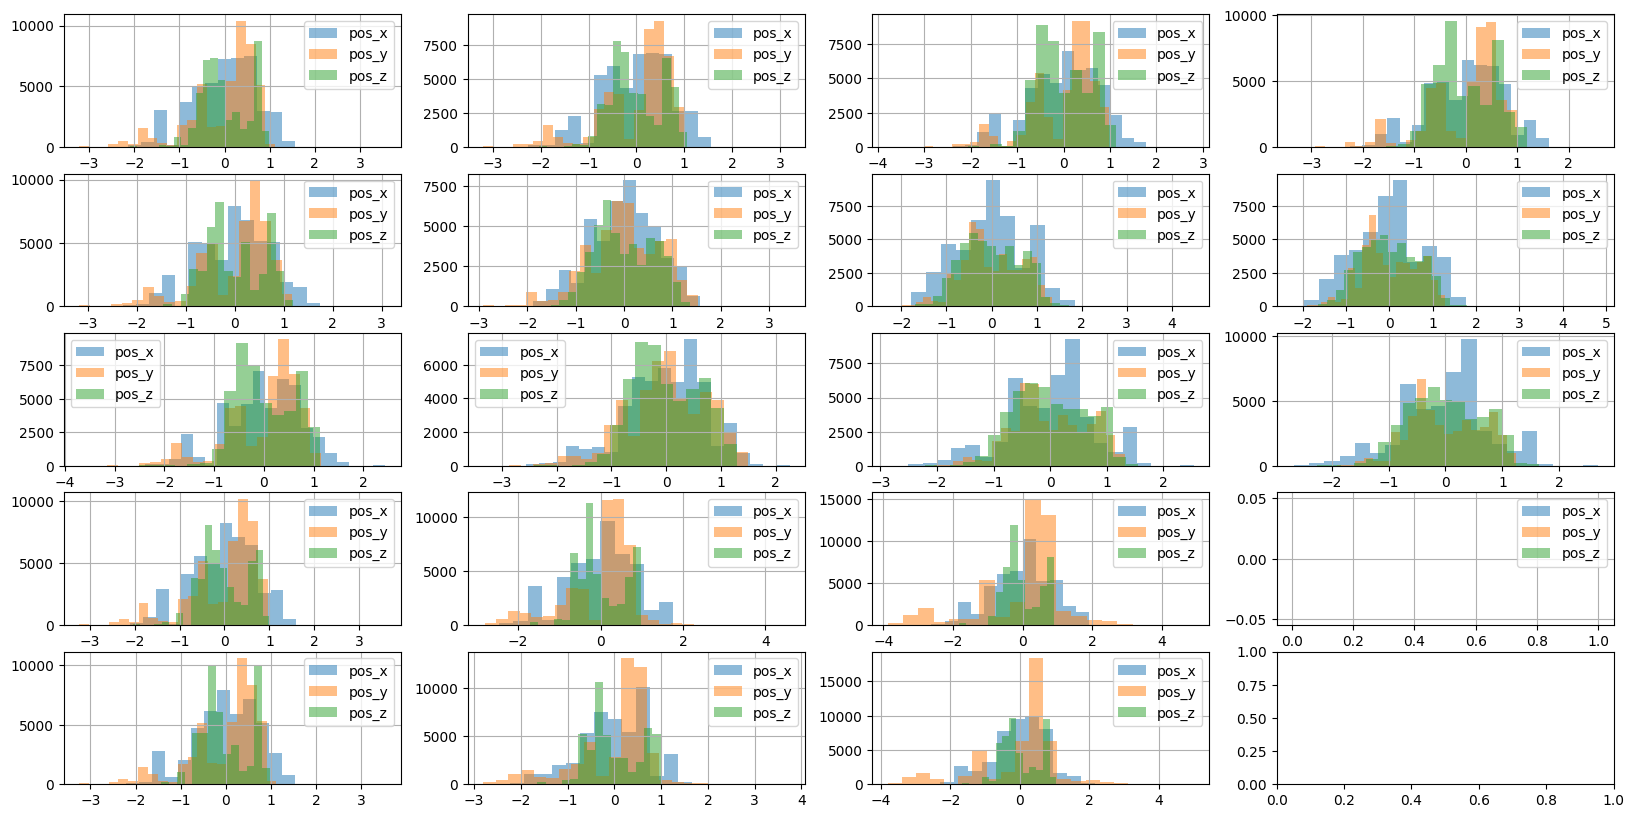

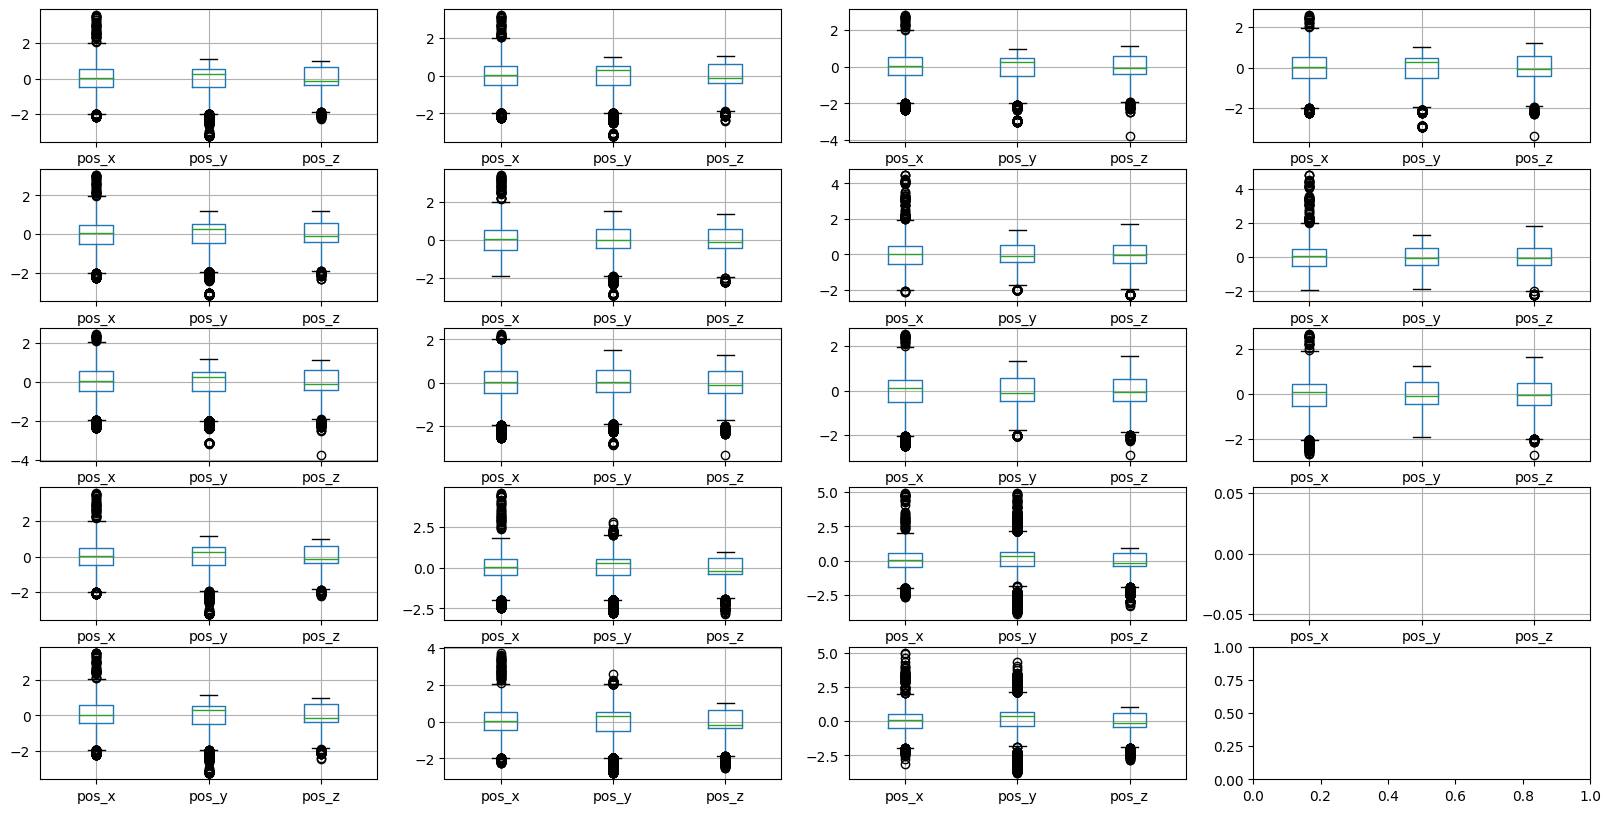

In [26]:
# Standardize indipendent joints

def standardize(df):
    for feature in FEATURES:
        m = df[feature].mean()
        s = df[feature].std()
        df[feature] = (df[feature] - m) / s
    return df

def strong_standardize(df):
    for feature in FEATURES:
        m = df[feature].mean()
        q = df[feature].quantile([0.25, 0.75])
        iqr = q[0.75] - q[0.25]
        df[feature] = (df[feature] - m) / iqr
    return df

z = exercise.groupby('joint', as_index=False).apply(strong_standardize).reset_index(drop=True)

# =================================================
# Show distribution of features on each joint

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20,10))
for joint, ax in zip(range(0, JOINTS_COUNT), axs.flat):
    plot_hist(z[z['joint'] == joint], ax=ax, alpha=0.5, bins=20)

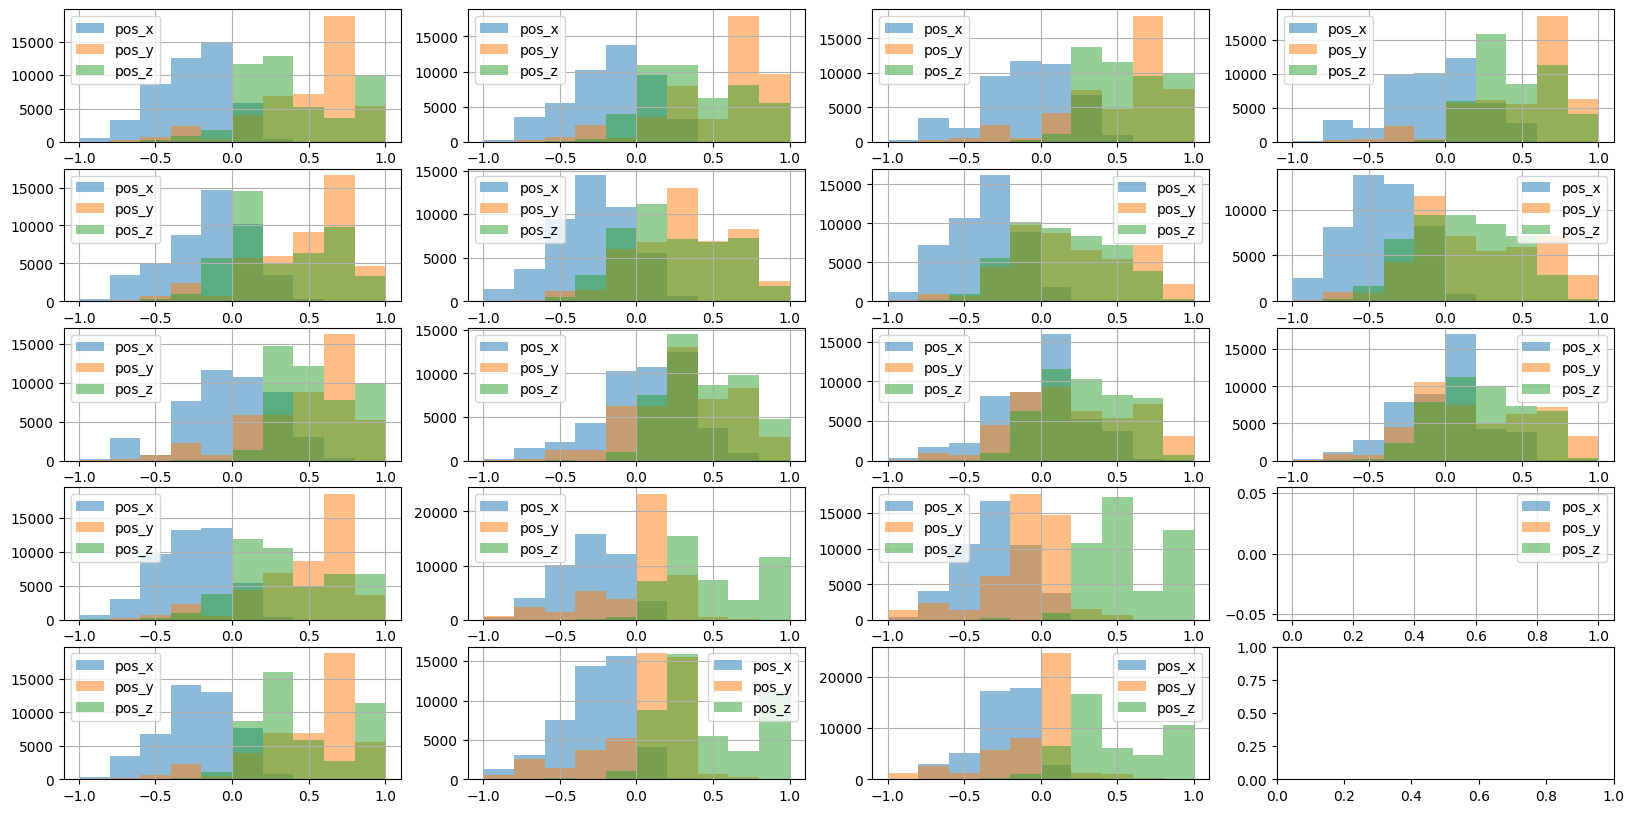

In [12]:
# Normalize all exercises

def normalize(df):
    for feature in FEATURES:
        max = df[feature].max()
        min = df[feature].min()
        df[feature] = 2.0 * (df[feature] - min) / (max - min) - 1.0

    print(df)
    return df

z = df.groupby(['exercise', 'joint'], as_index=False).apply(normalize).reset_index(drop=True)

z = z[z['exercise'] == 1]
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20,10))
for joint, ax in zip(range(0, JOINTS_COUNT), axs.flat):
    plot_hist(z[z['joint'] == joint], ax=ax, alpha=0.5)

In [41]:
# Standardize all exercises

z = df.groupby(['exercise', 'joint'], as_index=False).apply(strong_standardize).reset_index(drop=True)
z = z[z['subject'] == 'E_ID1']
print(z)

sample = z[['frame', 'joint', 'pos_x', 'pos_y', 'pos_z']]
sample.set_index(['frame', 'joint'], inplace=True)
print(sample)

frames_count = len(sample.index.get_level_values(0).unique())
joints_count = len(sample.index.get_level_values(1).unique())

sample = np.reshape(sample, (frames_count, 20, 3))
sample = torch.tensor(sample) # (F, J, 3)

def plot_joint(df, joint, ax):
        
        ax.plot(df[:, joint, 0], label='pos_x') # pos_x
        ax.plot(df[:, joint, 1], label='pos_y') # pos_y
        ax.plot(df[:, joint, 2], label='pos_z') # pos_z

        ax.set_title(f'joint = {SKELETON_JOINT_NAMES[joint]}')
        ax.set_ylabel('value')
        ax.set_xlabel('frames')
        ax.legend()

fig, ax = plt.subplots(nrows=(JOINTS_COUNT + 4 - 1) // 4, ncols=4, sharex=True, figsize=(20, 10))
fax = ax.flatten()
fax[-1].axis('off')
for joint in range(JOINTS_COUNT):
    plot_joint(sample, joint, fax[joint])
        
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

              type subject  exercise  frame  joint     pos_x     pos_y  \
4564     CG/Expert   E_ID1         1      0      0  0.458488  0.216868   
4565     CG/Expert   E_ID1         1      1      0  0.458218  0.216848   
4566     CG/Expert   E_ID1         1      2      0  0.458621  0.216831   
4567     CG/Expert   E_ID1         1      3      0  0.458666  0.216823   
4568     CG/Expert   E_ID1         1      4      0  0.458637  0.216651   
...            ...     ...       ...    ...    ...       ...       ...   
4419359  CG/Expert   E_ID1         5    938     20  0.319912  0.515451   
4419360  CG/Expert   E_ID1         5    939     20  0.318942  0.515056   
4419361  CG/Expert   E_ID1         5    940     20  0.317978  0.514652   
4419362  CG/Expert   E_ID1         5    941     20  0.316817  0.514034   
4419363  CG/Expert   E_ID1         5    942     20  0.313305  0.514143   

            pos_z  
4564    -0.208624  
4565    -0.208610  
4566    -0.208541  
4567    -0.208569  
4568    -0.

ValueError: cannot reshape array of size 375402 into shape (1664,20,3)